## Tobit regression with TensorFlow

Tobit regression fits the following model for non-negative data $ y $: 

$  y({\bf X}) = \max (0, w_0 + \sum_{i=1}^{N} w_i X_i + w_{N+1} \cdot \varepsilon) $  

Here $ X_i $ are predictors, $ \varepsilon \sim N(0,1) $ is a standard Gaussian noise, and $ w_{N+1} $ is the noise
volatility (standard deviation).

Our problem is to fit parameters $ N+2 $ parameters $ w_{i} $ for $ i = 0, \ldots, N+1 $ to the observed set of pairs $ \left({\bf X}_i, y_i \right) $  

We use synthetic data with known parameters to learn how to implement Tobit Regression in TensorFlow. 

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [1]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

try:
    from mpl_toolkits.mplot3d import Axes3D
except:
    pass

In [2]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="w3Hc-vZdEeehlBIKDnZryg" 
all_parts=["pLnY5", "RKR6p", "IU1pw", "ISVtY", "Cutr3"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [33]:
COURSERA_TOKEN = 'rT5PEcWZ0HhVImGS'# the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = 'bbalaji8@gmail.com'# the email

In [4]:
# utility function  to reset the TF graph to the same state each time
def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    

## Tobit Regression class

**Instructions**:
Complete the code for the calculation of loss function (the negative log-likelihood).

In [7]:
class Tobit_Regression:
    
    def __init__(self, n_features, learning_rate=0.005, L=0):
        
        self.input = tf.placeholder(tf.float32, [None, n_features], name="Input")
        self.target = tf.placeholder(tf.float32, [None, 1], name="Target")
        
        # the first weight is for the intercept, the last one is for a square root of the noise std 
        self.weights = tf.Variable(tf.random_normal([n_features + 2, 1]))
        
        # Augmented data matrix is obtained by adding a column of ones to the data matrix
        self.data_plus_bias = tf.concat([tf.ones([tf.shape(self.input)[0], 1]), self.input], axis=1)

        #######################################################################
        # MLE for Tobit regression 
        
        # noise volatility is obtained as a square of the last weight to ensure positivity 
        self.sigma = 0.0001 + tf.square(self.weights[-1])
        
        # term1 and term2 are just placeholders initialized such that the code runs
        # students need to initialize them appropriately to solve this assignment
#         self.term1 = tf.Variable(np.zeros(shape=(n_features + 2, 1)))
#         self.term2 = tf.Variable(np.zeros(shape=(n_features + 2, 1)))
        # THIS IS THE PART THAT STUDENTS ARE SUPPOSED TO WRITE THEMSELVES TO COMPLETE THE IMPLEMENTATION 
        # OF THE TOBIT REGRESSION MODEL
        
        # FOR THE ASSIGNMENT: complete the code for the calculation of loss function 
        # (the negative log-likelihood)
        ### START CODE HERE ### (≈ 6-7 lines of code)
        gauss = tf.distributions.Normal(loc = 0.0, scale = 1.0)
#         print("Tobit_Regression.__init__:")
#         print("  distribution:"); print(distribution)
#         outtmp = tf.nn.relu(tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]) + 
#                             self.weights[-1] * distribution.sample(tf.shape(self.input)[0]))
#         outtmp = tf.nn.relu(tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]))
        y_tmp = tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]) 
        y_I = tf.sign(tf.nn.relu(self.target - L))
        term_gtL = y_I * tf.log(((1.0 / self.sigma) * 
                                gauss.prob((self.target - y_tmp) / self.sigma)) + 
                               .00001)
        term_leL = (1.0 - y_I) * tf.log((1.0 - gauss.cdf((y_tmp - L) / self.sigma)) + 
                                        .00001)
        
        ### END CODE HERE ###
        self.loss = - tf.reduce_mean(term_gtL + term_leL)
        
        #####################################################################

        # Use Adam optimization for training
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), -self.loss)
        
        # prediction made from the model: Use a ReLU neuron!
        self.output = tf.nn.relu(tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]))
        
        # Check the output L1-norm error  
        self.output_L1_error = tf.reduce_mean(tf.abs(self.target - self.output))

    def generate_data(n_points,
                      n_features,
                      weights,
                      noise_std):

        # Bounds of [-1,1] in space of n_points x n_features
        np.random.seed(42)
        bias = np.ones(n_points).reshape((-1,1))
        low = - np.ones((n_points,n_features),'float')
        high = np.ones((n_points,n_features),'float')

        # simulated features are uniformally distributed on [-1,1].
        # The size n_points x n_features of array X is inferred by broadcasting of 'low' and 'high'
        X = np.random.uniform(low=low, high=high)
        
        # simulated noise
        noise = np.random.normal(size=(n_points, 1))
        
        # outputs    
        Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1,1)) + noise_std * noise

        # truncate negative values of Y    
        np.clip(Y, a_min=0, a_max=None, out=Y)

        return X, Y    

In [8]:
def gen_tobit_dataset(n_points, n_features, train_test_split=4):
    """
    Generate dataset for Tobit regression model and split it into training and test portions
    
    """
    # n_features + 1 weights (one for a constant feature)
    data_weights = np.array([-0.25, 0.5, 0.2, .1]) 
    noise_std = 0.1
    
    # Generate dataset
    X, Y = Tobit_Regression.generate_data(n_points=n_points,
                                           n_features=n_features,
                                           weights=data_weights,
                                           noise_std=noise_std)
    
    # split to the train and test set
    # 1/4 of the data is used for a test
    
    n_test = int(n_points / train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    return X_train, Y_train, X_test, Y_test

def train_model(n_features, learning_rate, n_steps=1000):
    """
    Train Tobit Regression model
    
    Return:
        a tuple of:
        - Model fitted weights, np.array
        - loss, double 
        - fitted noise std error, double
        - L1 error, double
    """
    # create an instance of the Tobit Regression class  
    model = Tobit_Regression(n_features=n_features, learning_rate=learning_rate)

    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for stepIx in range(0, n_steps):
#             (_, loss), weights, term1, term2 = sess.run(
#                 (model.train_step, model.weights, model.term1, model.term2), feed_dict={       
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={                    
                model.input: X_train,
                model.target: Y_train
                })
            print_step = False
            if ((stepIx < 1000) and (stepIx % 100 == 0)) or \
               ((stepIx <  100) and (stepIx %  10 == 0)) or \
               ( stepIx <   10                         ):
                print_step = True
#             if (stepIx < 10):
#                 print_step = True
#             elif ((stepIx >= 10) and (stepIx % 10 == 0)):
#                 print_step = True
                
            if print_step:
                print("\nstepIx:%4d| loss:%f" % (stepIx, 
                                    loss
                    ))
#                 print("\nstepIx:%4d| loss:%f| mean(term1+term2):%f| mean(term1): %f| mean(term2): %f" % (stepIx, 
#                                     loss, np.mean(term1+term2), np.mean(term1), np.mean(term2)
#                     ))
#                 print("  term1[self.target >  0.0][:5]:"); print(term1[np.ix_([0, 11, 17, 23, 25])].squeeze())
#                 print("  term2[self.target >  0.0][:5]:"); print(term2[np.ix_([0, 11, 17, 23, 25])].squeeze())
#                 print("  term1[self.target <= 0.0][:5]:"); print(term1[np.ix_([1, 2, 3, 4, 5])].squeeze())
#                 print("  term2[self.target <= 0.0][:5]:"); print(term2[np.ix_([1, 2, 3, 4, 5])].squeeze())
#                 print("  weights:" % ()); print(weights.squeeze())
#                 print("  term1.shape:%s" % (str(term1.shape)))
#                 print("  term1  :" % ()); print(term1.squeeze())
#                 print("  term2  :" % ()); print(term2.squeeze())                
    
        # predictions for the test set
        # std_model = weights[-1]**2     
        output, std_model = sess.run([model.output,model.sigma], 
                                     feed_dict={model.input: X_test})
        
        output_L1_error = sess.run(model.output_L1_error,
                                   feed_dict={model.input: X_test,
                                   model.target: Y_test})
        sess.close()
    return weights[:-1], loss, std_model[0], output_L1_error, output

def plot_results():        
    # Plot a projection of test prediction on the first two predictors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
    ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.show()

In [7]:
### BBI Grading Debugging ###
# n_points = 5000
# n_features = 3
# learning_rate = 0.05
# n_steps = 1000

# X_train, Y_train, X_test, Y_test = gen_tobit_dataset(n_points, n_features)
# plot_results()
# reset_graph()
# weights, loss, std_model, error_L1, output = train_model(n_features, learning_rate, n_steps)

# part_1=list(weights.squeeze())
# try:
#     part1 = " ".join(map(repr, part_1))
# except TypeError:
#     part1 = repr(part_1)
# submissions[all_parts[0]]=part1
# grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[0],all_parts,submissions)
# weights.squeeze()

In [8]:
# print("X_train:")
# print("  .shape: %s" % (str(X_train.shape)))

# XY_train = np.hstack((X_train, Y_train))
# print("XY_train.shape: %s" % (str(XY_train.shape)))
# print("XY_train examples:")
# print(XY_train[:5])

# Y1_train = (Y_train > 0.0)
# print("np.sum(Y1_train): %f" % (np.sum(Y1_train)))
# print(np.flatnonzero(Y_train)[:5])
# print("Y1_train[:20]"); print(Y1_train[:20])
# XY1_train = XY_train[Y_train > 0]
# print("XY1_train examples:"); print(XY_train[np.flatnonzero(Y_train), :])
# print(np.hstack((X_train, Y_train))[Y_train > 0][:5])
# print(np.hstack((X_train, Y_train))[Y_train > 0][:5])

In [9]:
# reset_graph()
# learning_rate = 0.05
# weights, loss, std_model, error_L1, output = train_model(n_features, learning_rate, n_steps)

In [10]:
# reset_graph()
# learning_rate = 0.01
# weights, loss, std_model, error_L1, output = train_model(n_features, learning_rate, n_steps)

In [11]:
# reset_graph()
# learning_rate = 0.10
# weights, loss, std_model, error_L1, output = train_model(n_features, learning_rate, n_steps)

In [11]:
### GRADED PART (DO NOT EDIT) ###
n_points = 5000
n_features = 3
learning_rate = 0.05
n_steps = 1000

X_train, Y_train, X_test, Y_test = gen_tobit_dataset(n_points, n_features)
reset_graph()
weights, loss, std_model, error_L1, output = train_model(n_features, learning_rate, n_steps)

part_1=list(weights.squeeze())
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[0],all_parts,submissions)
weights.squeeze()
### GRADED PART (DO NOT EDIT) ###


stepIx:   0| loss:-8.842211

stepIx:   1| loss:-8.318393

stepIx:   2| loss:-7.714983

stepIx:   3| loss:-7.050903

stepIx:   4| loss:-6.344158

stepIx:   5| loss:-5.609383

stepIx:   6| loss:-4.869526

stepIx:   7| loss:-4.149171

stepIx:   8| loss:-3.484373

stepIx:   9| loss:-2.912947

stepIx:  10| loss:-2.463206

stepIx:  20| loss:-1.194293

stepIx:  30| loss:-1.035359

stepIx:  40| loss:-0.971992

stepIx:  50| loss:-0.923419

stepIx:  60| loss:-0.875775

stepIx:  70| loss:-0.825529

stepIx:  80| loss:-0.771663

stepIx:  90| loss:-0.714185

stepIx: 100| loss:-0.653841

stepIx: 200| loss:-0.025679

stepIx: 300| loss:0.134133

stepIx: 400| loss:0.134144

stepIx: 500| loss:0.134144

stepIx: 600| loss:0.134144

stepIx: 700| loss:0.134144

stepIx: 800| loss:0.134140

stepIx: 900| loss:0.134144
Submission successful, please check on the coursera grader page for the status


array([-0.24247026,  0.49173024,  0.19827977,  0.09300683], dtype=float32)

In [12]:
### GRADED PART (DO NOT EDIT) ###
part_2=[loss, std_model, error_L1]
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)  
    
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:2],all_parts,submissions)
[loss, std_model, error_L1]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.13414387, 0.098345175, 0.019833893]

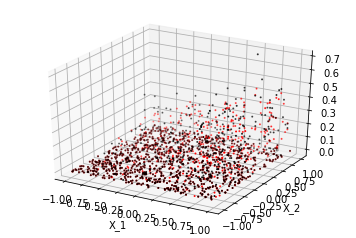

In [13]:
plot_results()

### Fitting Linear regression and Neural Network to Non-linear data

In [14]:
def generate_data(n_points=10000, n_features=3, use_nonlinear=True, 
                    noise_std=0.1, train_test_split = 4):
    """
    Arguments:
    n_points - number of data points to generate
    n_features - a positive integer - number of features
    use_nonlinear - if True, generate non-linear data
    train_test_split - an integer - what portion of data to use for testing
    
    Return:
    X_train, Y_train, X_test, Y_test, n_train, n_features
    """
    # Linear data or non-linear data?
    if use_nonlinear:
        weights = np.array([[1.0, 0.5, 0.2],[0.5, 0.3, 0.15]], dtype=np.float32)
    else:
        weights = np.array([1.0, 0.5, 0.2], dtype=np.float32)
    
    np.random.seed(42)
    bias = np.ones(n_points).reshape((-1,1))
    low = - np.ones((n_points,n_features), dtype=np.float32)
    high = np.ones((n_points,n_features), dtype=np.float32)
    
    X = np.random.uniform(low=low, high=high)
    noise = np.random.normal(size=(n_points, 1))
    noise_std = 0.1
    
    if use_nonlinear:
        Y = (weights[0,0] * bias + np.dot(X, weights[0, :]).reshape((-1,1)) + 
             np.dot(X*X, weights[1, :]).reshape([-1,1]) +
             noise_std * noise)
    else:
        Y = (weights[0] * bias + np.dot(X, weights[:]).reshape((-1,1)) + 
             noise_std * noise)
    
    n_test = int(n_points/train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    
    return X_train, Y_train, X_test, Y_test, n_train, n_features

X_train, Y_train, X_test, Y_test, n_train, n_features = generate_data(use_nonlinear=False)
X_train.shape, Y_train.shape

((7500, 3), (7500, 1))

In [15]:
np.random.seed(42)
X_train, Y_train, X_test, Y_test, n_train, n_features = generate_data(use_nonlinear=True)
X_train.shape, Y_train.shape

((7500, 3), (7500, 1))

**Instructions**
Implement sklearn_lin_regress() function which returns a tuple of

- coefficients of linear regression
- an instance of LinearRegression class trained to X_train, Y_train


In [16]:
# GRADED FUNCTION: sklearn_lin_regress
def sklearn_lin_regress(X_train, Y_train):
    """
    Arguments:
    X_train  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_train - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    Return: a tuple of 
      - np.array of size (k+1 by 1) of regression coefficients
      - an instance of LinearRegression
    """
    from sklearn.linear_model import LinearRegression
    lr_model = None
    theta_sklearn = np.array([], dtype=np.float32)
    ### START CODE HERE ### (≈ 2-3 lines of code)

    lr_model = LinearRegression()
    lr_model.fit(X_train, Y_train)
    print("sklearn_lin_regress: intercept_.shape:%s| coef_.shape:%s" % (str(lr_model.intercept_.shape), 
                                                                        str(lr_model.coef_.shape)))
    theta_sklearn = np.concatenate((lr_model.intercept_.reshape((-1, 1)), lr_model.coef_.reshape((-1, 1))))
    
    ### END CODE HERE ###
    return theta_sklearn, lr_model

In [17]:
# you can make submission with answers so far to check yourself at this stage
### GRADED PART (DO NOT EDIT) ###
theta_sklearn, lr_model = sklearn_lin_regress(X_train, Y_train)

part_3 = list(theta_sklearn.squeeze())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
    
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:3],all_parts,submissions)

theta_sklearn.squeeze()
### GRADED PART (DO NOT EDIT) ###

sklearn_lin_regress: intercept_.shape:(1,)| coef_.shape:(1, 3)
Submission successful, please check on the coursera grader page for the status


array([ 1.31552735,  1.00221739,  0.50122384,  0.19928303])

LinearRegression.score() computes $R^2$ coefficient. The coefficient $R^2$ is defined as $(1 - \frac{u}{v})$, where u is the residual sum of squares $\sum (y\_true - y\_pred)^2$ and v is the total sum of squares $\sum (y\_true - \bar{y\_true})^2$

In [18]:
# you can make submission with answers so far to check yourself at this stage
### GRADED PART (DO NOT EDIT) ###
# calculate Linear Regression score
model_score = 0.
if lr_model is not None:
    model_score = lr_model.score(X_test, Y_test)
part4=str(model_score)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:4],all_parts,submissions)
model_score
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.9065452090081394

### Neural Network with Tensorflow 

**Instructions**

Construct two-layer Neural Network utilizing neuron_layer() function. The number of nodes in two hidden layers are defined by n_hidden1 and n_hidden2, respectively. Use Gradient Descent Optimizer.

The train the network using X_train / y_train and compute accuracy of the prediction using X_test data set.

In [19]:
def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch
    
def neuron_layer(X, n_neurons, name, activation_fn=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation_fn is not None:
            return activation_fn(Z)
        else:
            return Z

In [27]:
n_hidden1 = 100
n_hidden2 = 120
n_outputs = 1 # single value prediction
n_inputs = X_test.shape[1]

reset_graph() # This shd be in model.fit ?
# Next 2 lines shd be in model.__init__ ?
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None), name="y")

### START CODE HERE ### (≈ 10-15 lines of code)

# create an instance of the Tobit Regression class
class RegressorNNTf:
    
    def __init__(self, X, y, n_hidden1, n_hidden2, n_outputs, learning_rate = 0.01):
        
        self.X = X
        self.y = y
        
        out_L1 = neuron_layer(self.X, n_hidden1, 'Layer1', activation_fn = tf.tanh)
        out_L2 = neuron_layer(out_L1, n_hidden2, 'Layer2', activation_fn = tf.nn.relu)
        self.output = neuron_layer(out_L2, n_outputs,  'LayerF', activation_fn = None)
        
        self.loss_mse = tf.reduce_mean(tf.square(self.output - self.y))
        self.train_step = (tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss_mse), -self.loss_mse)

model = RegressorNNTf(X, y, n_hidden1, n_hidden2, n_outputs)

### END CODE HERE ###

init = tf.global_variables_initializer()

In [37]:
learning_rate = 0.01
n_epochs = 200
batch_size = 60
num_rec = X_train.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

### START CODE HERE ### (≈ 9-10 lines of code)
with tf.Session() as sess:
    sess.run(init)
    
    for epochIx in range(0, n_epochs):
        for miniBatchIx in range(0, n_batches):
            X_batch, y_batch = random_batch(X_train, Y_train, batch_size)
            (_, loss) = sess.run((model.train_step), feed_dict = {
                model.X: X_batch,
                model.y: y_batch
            })
            
        print_epoch = False
        if (epochIx == n_epochs - 1) or \
           ((epochIx < 1000) and (epochIx % 100 == 0)) or \
           ((epochIx <  100) and (epochIx %  10 == 0)) or \
           ( epochIx <   10                         ):
            print_epoch = True
                
        if print_epoch:
            print("\nepochIx:%4d| loss:%f" % (epochIx, loss
#                                     , np.mean(term1+term2), np.mean(term1), np.mean(term2)
                ))

    output_test = sess.run([model.output], feed_dict = {
        model.X: X_test,
        model.y: Y_test
    })
    
#     acc_test = np.sum(np.isclose(output_test, Y_test)) * 1.0 / Y_test.shape[0]
    acc_test = 1.0 - np.sqrt(np.mean(np.square(output_test - Y_test)))
    
    print("\nacc_test:%f" % (acc_test))
    
### END CODE HERE ###


epochIx:   0| loss:-0.020913

epochIx:   1| loss:-0.012600

epochIx:   2| loss:-0.008605

epochIx:   3| loss:-0.006256

epochIx:   4| loss:-0.004783

epochIx:   5| loss:-0.003891

epochIx:   6| loss:-0.003240

epochIx:   7| loss:-0.002711

epochIx:   8| loss:-0.002302

epochIx:   9| loss:-0.002019

epochIx:  10| loss:-0.001800

epochIx:  20| loss:-0.000812

epochIx:  30| loss:-0.000515

epochIx:  40| loss:-0.000377

epochIx:  50| loss:-0.000313

epochIx:  60| loss:-0.000274

epochIx:  70| loss:-0.000245

epochIx:  80| loss:-0.000222

epochIx:  90| loss:-0.000202

epochIx: 100| loss:-0.000184

epochIx: 199| loss:-0.000080

acc_test:0.780868


In [36]:
### GRADED PART (DO NOT EDIT) ###
part5=str(acc_test)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:5],all_parts,submissions)
acc_test
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.21913228554995798